# Detection and Quantification in ISCAT

In this notebook we will investigate how to detect and quantify particles in ISCAT. 

The notebook contains the following sections:




## 1. Imports

In [1]:
import sys
sys.path.insert(0, "../") # Adds the module to path
import deeptrack as dt

In [2]:
import deeplay as dl

In [3]:
import help_files as hp #Helper functions for the notebook.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [5]:
DEV = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running code on device: ({DEV}) when possible")

Running code on device: (cuda) when possible


## 2. Detection in ISCAT

Let's start by loading in data in the ISCAT regime.

In [6]:
data = np.load("../data/iscat_data.npy") #Quantitative field
labels = np.load("../data/iscat_labels.npy") #Labels for the particles
centroids = labels[:, 0:2] #Centroids of the particles

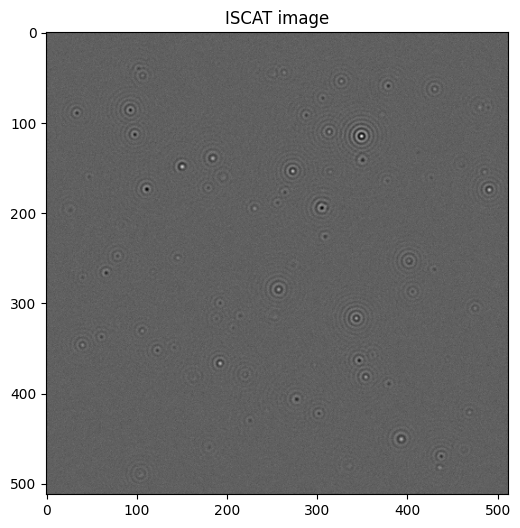

In [7]:
plt.figure(figsize=(6,6))
plt.imshow(data[...,0], cmap="gray")
plt.title("ISCAT image")
plt.show()

In [8]:
#Subtract 1 so data is centered around 0
data = data - 1

### 2.1 Detecting particles using a classical method


#### 2.1.1 - Radial Variance Transform
xxx

We construct a pipeline for the Radial Variance Transform(RVT) which also incorporates a local maxima step to detect the centroids of the particles.

#### 2.1.2 - Visualizing the detections from RVT
xxx

In [9]:
###Settings for Radial Variance Transform pipeline
rmin, rmax = 1, 55
th_scale = 2.5
min_distance = 8

In [10]:
detections_rvt = hp.rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance)

Text(0.5, 1.0, 'Detections with Radial Variance Transform')

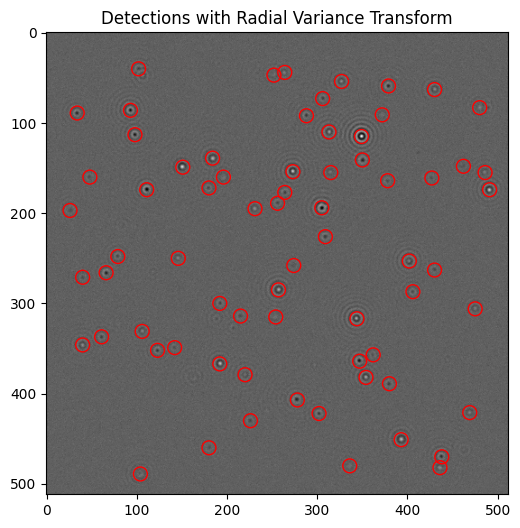

In [11]:
plt.figure(figsize=(6,6))
plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections_rvt[:,1], detections_rvt[:,0], s = 100, facecolors='none', edgecolors='r')
plt.title("Detections with Radial Variance Transform") 

In [12]:
radius = 6 # Radius of the particle in pixels
centroids = labels[:, :2] # We use the labels as the ground truth
mask = np.zeros_like(data[...,0])

In [13]:
GT_particles = hp.add_bin_circles(centroids, radius, mask)

Text(0.5, 1.0, 'Ground truth particles')

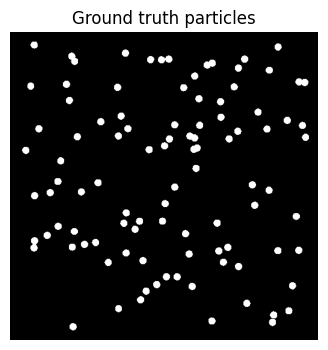

In [14]:
plt.figure(figsize=(4, 4))
plt.imshow(GT_particles, cmap="gray")
plt.axis("off")
plt.title("Ground truth particles")

In [15]:
F1_score_rvt = hp.get_F1_score(hp.add_bin_circles(detections_rvt, radius, mask), GT_particles)
print(f"F1 score for RVT: {round(F1_score_rvt, 3)*100}%")

F1 score for RVT: 77.5%


### 2.2 Detecting particles using LodeSTAR model

xxx

#### 2.2.1  Prepare the Training Crop
We will use a set of crops for a few particles to train the neural network.

In [16]:
crop_size = 64
labels_idx = [11, 33, 63, 84]
downsample = True

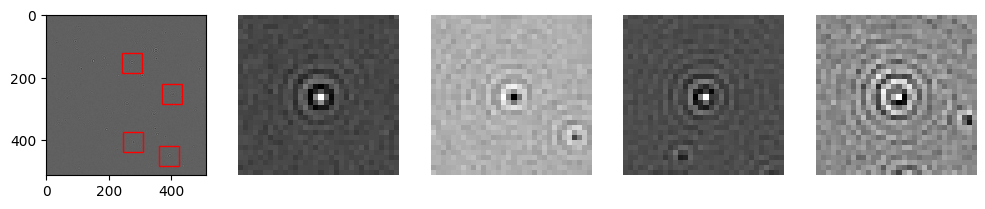

In [17]:
import matplotlib.patches as patches

# We crop the image around the particle (based on the labels) - One could also use the detections or manually select a particle.
crop_x0s = np.array([int(labels[label_idx, 0] - crop_size/2) for label_idx in labels_idx])
crop_y0s = np.array([int(labels[label_idx, 1] - crop_size/2) for label_idx in labels_idx])

#Check so crops within data
valid_coords = []
for i, coords in enumerate(zip(crop_x0s, crop_y0s)):
    #check so that x and 
    if coords[0]-crop_size/2 > 0 and coords[0]+crop_size/2 < data.shape[0] and coords[1]-crop_size/2 > 0 and coords[1] + crop_size/2 < data.shape[1]:
        valid_coords.append(i)

crop_x0s = np.array([crop_x0s[i] for i in valid_coords])
crop_y0s = np.array([crop_y0s[i] for i in valid_coords])
    
crops = np.array([data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :] for crop_x0, crop_y0 in zip(crop_x0s, crop_y0s)])

plt.figure(figsize=(12, 6))

plt.subplot(1, len(labels_idx)+1, 1)
plt.imshow(data[...,0], cmap="gray")

for crop_x0, crop_y0 in zip(crop_x0s, crop_y0s):
    plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                        linewidth=1, edgecolor="r",
                                        facecolor="none"))

if downsample:
    import skimage
    crops = skimage.measure.block_reduce(crops, (1, 2, 2, 1))
    crop_size = 32

for i, crop in enumerate(crops):
    plt.subplot(1, len(labels_idx)+1, 2+i)
    plt.imshow(crop[...,0], cmap="gray")
    plt.axis('off')
plt.show()

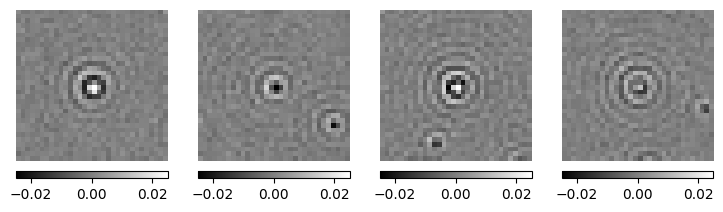

In [18]:
plt.figure(figsize=(9,3))
for i, crop in enumerate(crops):
    plt.subplot(1, len(labels_idx), 1+i)
    im = plt.imshow(crop[...,0], cmap="gray")
    plt.colorbar(im, fraction=0.046, pad=0.04, orientation = "horizontal")
    #set colorbar range to -0.1, 0.1
    im.set_clim(-0.025, 0.025)
    plt.axis('off')

#### 2.2.2  Prepare pipeline and train model
We will create a pipeline for training the LodeSTAR model

In [19]:
x,y=np.meshgrid(
    np.arange(crop_size)-crop_size,
    np.arange(crop_size)-crop_size
    )

def grad(dx1, dy1):
    def inner(image):
        image[...,0]+=dx1*x+dy1*y
        return image
    return inner

addgrad=dt.Lambda(
    grad,
    dx1=lambda: .01/crop_size*np.random.randn(),
    dy1=lambda: .01/crop_size*np.random.randn(),
    )

In [20]:
training_pipeline = (
    dt.Value(lambda: crops[np.random.randint(len(crops))])
    >> addgrad
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 5e-3)
    >> dt.Multiply(lambda: np.random.uniform(-3, 3))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=5000, replace=False)

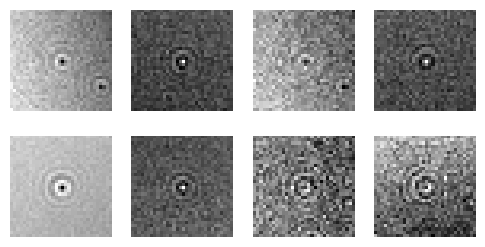

In [21]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(6, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.axis("off")

In [22]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=2e-4)).build().to(DEV)

In [23]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=1)
    trainer.fit(lodestar, dataloader)
else:
    lodestar.load_state_dict(torch.load("../models/iscat/lodestar_tracking.pth"))
    lodestar.eval()
lodestar = lodestar.to(DEV)

#### 2.2.3  Visualize result from trained LodeSTAR model

xxx

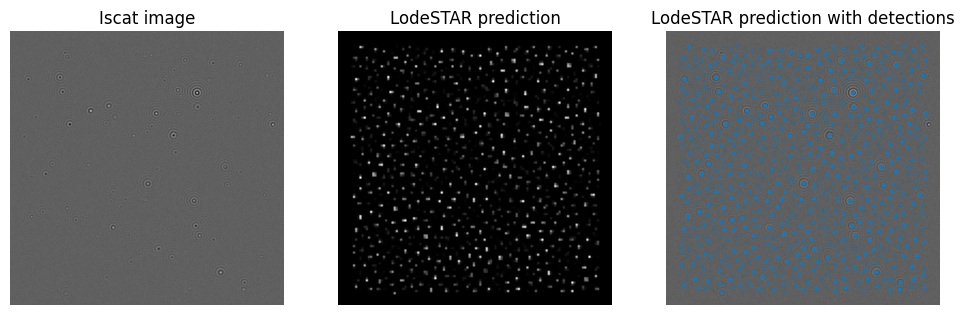

In [24]:
if downsample:
    datav2 = skimage.measure.block_reduce(data, (2, 2, 1))
    torch_image = torch.from_numpy(datav2).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
    factor = 2
else:
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
    factor = 1
    
prediction = lodestar(torch_image)[0].cpu().detach().numpy()
x, y, rho = prediction[0]*factor, prediction[1]*factor, prediction[-1]

#if x or y is negative, add half of image size to make it positive (BUG when loading model from file)
if np.min(x) < 0 and np.min(y) < 0:
    x = (x + x.shape[0])
    y = (y + x.shape[0])

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Iscat image")
plt.imshow(data[...,0], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("LodeSTAR prediction")
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("LodeSTAR prediction with detections")
plt.imshow(data[...,0], cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

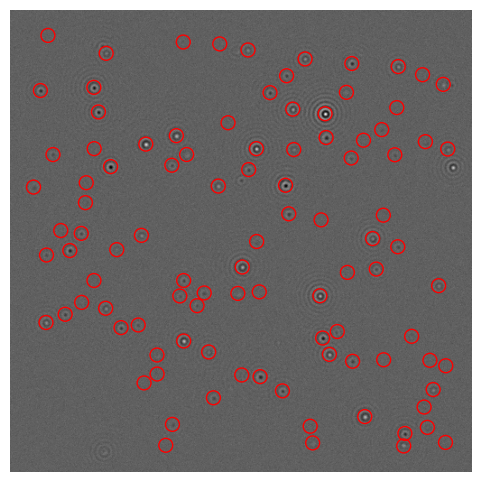

In [25]:
alpha = 0.5
beta = 0.5
cutoff = 0.990
mode = "quantile"#"constant"

plt.figure(figsize=(6, 6))
if downsample:
    datav2 = skimage.measure.block_reduce(data, (2, 2, 1))
    torch_image = torch.from_numpy(datav2).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
    factor = 2
else:
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
    factor = 1

detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                mode=mode, cutoff=cutoff)[0]

plt.imshow(data[...,0], cmap="gray")
plt.scatter(detections[:,1]*factor, detections[:,0]*factor, s = 100, facecolors='none', edgecolors='r')
plt.axis("off")

plt.show()

In [26]:
# F1 score for LodeSTAR
F1_score_l = hp.get_F1_score(
    hp.add_bin_circles(detections*2, radius, mask), 
    GT_particles)
print(f"F1 score for LodeSTAR: {round(F1_score_l, 3)*100}%")

F1 score for LodeSTAR: 69.1%


## 3 - Quantification of particle properties in ISCAT

xxx

In [27]:
padsize = 20 # Padding size, 20 pixels gives a total size of 40x40 pixels.

In [28]:
rois = hp.get_rois(data, centroids, padsize)

In [29]:
# Calculate the polarizabilities for all the particles
polarizabilities_rois = hp.get_polarizability(labels[:,3]*1e6, labels[:,4])
form_factors = hp.form_factor(labels[:,3]*1e6, wavelength = 0.532)
signal_rois = np.array(
    [hp.signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, polarizabilities_rois)]
    )

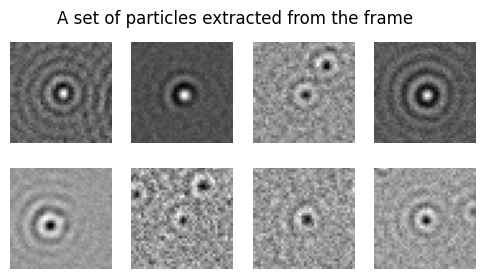

In [30]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of particles extracted from the frame")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,0], cmap="gray")
    plt.axis("off")

### 3.2 Quantifying particle signal using a 2DCNN

#### 3.2.1 Defining the optical system

xxx

In [31]:
IMAGE_SIZE = 40
NA = 1
MAGNIFICATION = 1
WAVELENGTH = 532e-9
RESOLUTION = 1.14e-7

In [32]:
optics = dt.ISCAT(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination_angle=np.pi,
)

#### 3.2.2 Defining the particle(s)

In [33]:
RADIUS_RANGE = (25e-9, 250e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [34]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.randn(2),
    z=lambda: np.random.randn() * 5,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
)

#### 3.2.3 Create dataset of particles

In [35]:
def add_noise(snr=10):
    def inner(image):
        slevel=np.std(image)
        
        nlevel=slevel/snr
        image+=nlevel*np.random.randn(*image.shape)
        return image
    return inner

noise_snr = dt.Lambda(add_noise, snr=lambda: np.random.uniform(0.5, 5))

In [36]:
dataset = optics(particle >> dt.Gaussian(sigma=1e-5)) >> dt.Subtract(1) >> noise_snr  

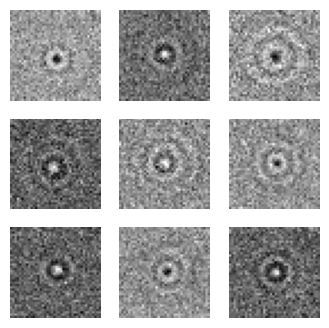

In [37]:
#3x3 grid of augmented images
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = dataset.update().resolve(refractive_index = 1.4, radius = 100e-9, snr = 0.5)
    plt.imshow(img[...,0], cmap="gray")
    plt.axis('off')

#### 3.2.4 Defining the training label

We extract the parameters we want the network to learn. This is the polarizability of the particle.

In [38]:
MIN, MAX = hp.signal_range(RADIUS_RANGE, REFRACTIVE_INDEX_RANGE)
print("Signal range:", MIN, MAX)

Signal range: 1.2125533639949535e-08 0.011968181042412427


In [39]:
def get_label_iscat(radius, refractive_index, wavelength=WAVELENGTH*1e6, nm = 1.333, factor = 1):
    def inner(image):
        #Calculate the standard deviation of the image
        std=np.std(image)

        #Calculate the polarizability and form factor
        pol = hp.get_polarizability(radius=radius*1e6, refractive_index=refractive_index, refractive_index_medium=nm)
        form_factor = hp.form_factor(radius = radius*1e6, nm = nm, wavelength = wavelength)

        #Calculate the signal
        signal = hp.signal_iscat(form_factor, pol) / (factor*MAX*std)
    
        return np.expand_dims(signal, -1)
    return inner


#### 3.2.5 Defining quantification model (2DCNN)
xxx

In [40]:
conv = dl.ConvolutionalNeuralNetwork(
    in_channels = 1, 
    hidden_channels=[16, 32, 64], 
    out_channels = 64,
    pool = dl.torch.nn.MaxPool2d(kernel_size=2),
    out_activation=dl.torch.nn.LeakyReLU(0.1),
    )

mlp = dl.MultiLayerPerceptron(
    in_features = None, 
    hidden_features = [64, 32], 
    out_activation = dl.torch.nn.LeakyReLU(0.1), 
    out_features=1)

net = dl.Sequential(
    conv,
    mlp
)

In [41]:
regressor = dl.Regressor(
    model=net,
    loss= dl.torch.nn.L1Loss(),#dl.torch.nn.MSELoss(),#MeanAbsolutePercentageError(),,#
    optimizer=dl.Adam(),
)
cnn_regressor = regressor.create()
cnn_regressor = cnn_regressor.to(DEV)

#### 3.2.6 Training of the model
xxx

In [42]:
def scale_std(factor=1):
    """
    Returns a function that scales an image by the standard deviation of its pixel values,
    divided by the specified factor.
    
    Parameters:
    - factor (int or float): The factor to divide the standard deviation by.
    
    Returns:
    - function: A function that scales an image.
    """
    def inner(image):
        std = np.std(image)  # Calculate the standard deviation of the image
        return image / (factor * std)  # Scale the image by the calculated value
    return inner
    
#Set the scale function    
scale = dt.Lambda(scale_std, factor=10)

In [43]:
#Pipeline for generating images and labels.
image_and_signal_pipeline = dataset >> scale & dataset >> dt.Lambda(get_label_iscat, radius=particle.radius, refractive_index=particle.refractive_index, factor=10)

In [44]:
training_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=100000, replace=False)
dataloader = dl.DataLoader(training_dataset, batch_size=32, shuffle=True)

#Generate new data.
val_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=1000)
val_dataloader = dl.DataLoader(val_dataset, batch_size=32, shuffle=False)

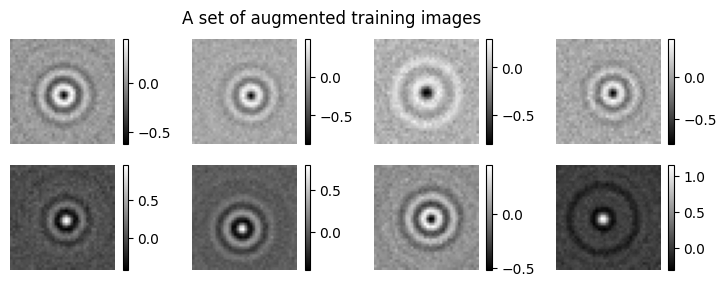

In [45]:
batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(9, 3))
plt.suptitle("A set of augmented training images")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.colorbar()
    plt.axis("off")

In [46]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=50)
    trainer.fit(cnn_regressor, dataloader, val_dataloader)
else:
    cnn_regressor.load_state_dict(torch.load("../models/iscat/cnn_regressor.pth"))
    cnn_regressor.eval()
cnn_regressor = cnn_regressor.to(DEV)


#### 3.2.7 Validating the model on simulated data and ROIs from frame.
xxx


In [47]:
#Predict the signal
predictions = []
labels_ = []
for batch in val_dataloader:
    predictions.append(cnn_regressor(batch[0].to(DEV)))
    labels_.append(batch[1])

#Concatenate the predictions and labels
predictions = torch.concatenate(predictions)[:, 0].detach().cpu().numpy()
labels_ = torch.concatenate(labels_)[:, 0].detach().cpu().numpy()

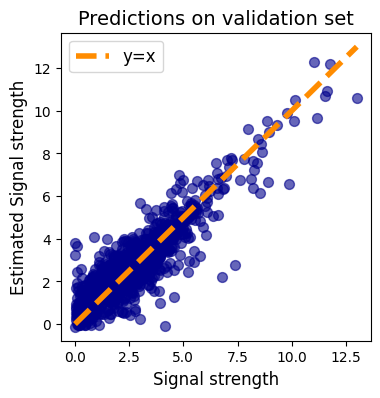

In [48]:
plt.figure(figsize=(4, 4))
plt.scatter(labels_, predictions, color="darkblue", alpha=0.6, s=50)
plt.plot([np.min(labels_), np.max(labels_)], [np.min(labels_), np.max(labels_)], color = 'darkorange', linestyle="--", linewidth=4, label="y=x")
plt.xlabel("Signal strength", fontsize=12)
plt.ylabel("Estimated Signal strength", fontsize=12)
plt.legend(fontsize=12)
plt.title("Predictions on validation set", fontsize=14)
plt.show()


In [49]:
#Predict on the rois
predictions_rois = [
    cnn_regressor((torch.from_numpy(roi)/np.std(roi*10)).permute(2, 0, 1).unsqueeze(0).to(DEV)) 
    for roi in rois]

predictions_rois = np.array([pred.detach().cpu().numpy()[0, 0] for pred in predictions_rois])
stds = np.array([np.std(roi) for roi in rois])
predictions_rois = predictions_rois * stds

Text(0.5, 1.0, 'Predictions on ROIs')

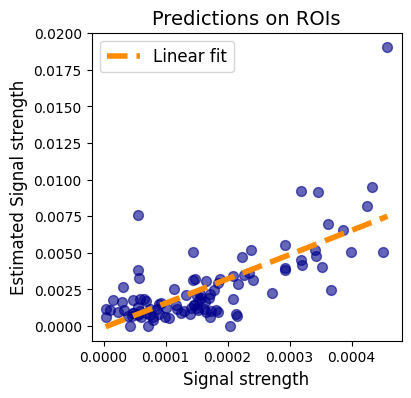

In [50]:
plt.figure(figsize=(4, 4))
plt.scatter(signal_rois, predictions_rois, color="darkblue", alpha=0.6, s=50)
coefficients = np.polyfit(signal_rois, predictions_rois, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(signal_rois.min(), signal_rois.max(), 100)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, color = 'darkorange', linestyle="--", linewidth=4, label="Linear fit")
plt.xlabel("Signal strength", fontsize=12)
plt.ylabel("Estimated Signal strength", fontsize=12)
plt.legend(fontsize=12)
plt.title("Predictions on ROIs", fontsize=14)

### 3.4 Investigating the signal as dependence while keeping either refractive index or radius fixed.

#### 3.4.1 Fix refractive index 

In [51]:
FIX_RI = 1.4
RADIUS_RANGE = np.linspace(25e-9, 250e-9, 100)
samples_per_case = 10
noise_snr = 5
radiuses = np.concatenate([np.repeat(x, samples_per_case) for x in RADIUS_RANGE])

In [52]:
DATA = []
for i, rad in enumerate(RADIUS_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/{len(RADIUS_RANGE)}")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index = FIX_RI, radius = rad, snr = noise_snr)
        DATA.append(im)
DATA = np.array(DATA)
#Normalize the data with the standard deviation and a factor of 10
stds = np.std(DATA, axis =(1,2,3), keepdims=True)*10
DATA = DATA / stds

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [53]:
# Get the theoretical polarizabilities
theoretical_pol = hp.get_polarizability(radiuses, FIX_RI)
form_factors = hp.form_factor(radiuses*1e6, wavelength = 0.532)
theoretical_signal = np.array(
    [hp.signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, theoretical_pol)]
    )

In [54]:
signal_sum_cnn_fix_ri = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0] * np.squeeze(stds)

In [55]:
#Normalize the signals
signal_sum_cnn_fix_ri = signal_sum_cnn_fix_ri / signal_sum_cnn_fix_ri.mean()
theoretical_signal = theoretical_signal / theoretical_signal.mean()

Text(0.5, 1.0, 'Theoretical signal vs. signal estimated with a 2DCNN')

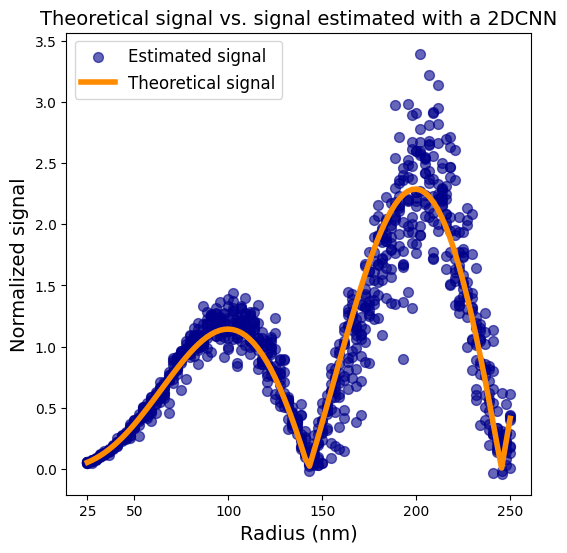

In [56]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, signal_sum_cnn_fix_ri, color="darkblue", alpha=0.6, s=50, label = 'Estimated signal')

#Line for theoretical signal
plt.plot(radiuses, theoretical_signal, linestyle="-", linewidth=4, label="Theoretical signal", color = 'darkorange')

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9, 250e-9], ["25", "50", "100", "150", "200", "250"])
plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Normalized signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical signal vs. signal estimated with a 2DCNN", fontsize=14)

#### 3.4.1 Fix radius 

In [57]:
FIX_RADIUS = 100e-9
RI_RANGE = np.linspace(1.37, 1.6, 100)
samples_per_case = 10
noise_snr = 5
riis = np.concatenate([np.repeat(x, samples_per_case) for x in RI_RANGE])

In [58]:
DATA = []
for i, ri in enumerate(RI_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/100")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index = ri, radius = FIX_RADIUS, snr = noise_snr)
        DATA.append(im)
DATA = np.array(DATA)

#Normalize the data with the standard deviation and a factor of 10
stds = np.std(DATA, axis =(1,2,3), keepdims=True)*10
DATA = DATA / stds

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [59]:
# Get the theoretical signals
theoretical_pol = hp.get_polarizability(FIX_RADIUS*1e6, riis)
form_factors = hp.form_factor(FIX_RADIUS*1e6, wavelength = 0.532)
form_factors = np.repeat(form_factors, len(riis))
theoretical_signal = np.array(
    [hp.signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, theoretical_pol)]
    )

In [60]:
signal_sum_cnn_fix_radius = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0] * np.squeeze(stds)

In [61]:
#Normalize the signals
signal_sum_cnn_fix_radius = signal_sum_cnn_fix_radius / signal_sum_cnn_fix_radius.mean()
theoretical_signal = theoretical_signal / theoretical_signal.mean()

Text(0.5, 1.0, 'Theoretical Signal vs. Signal estimated with a 2DCNN')

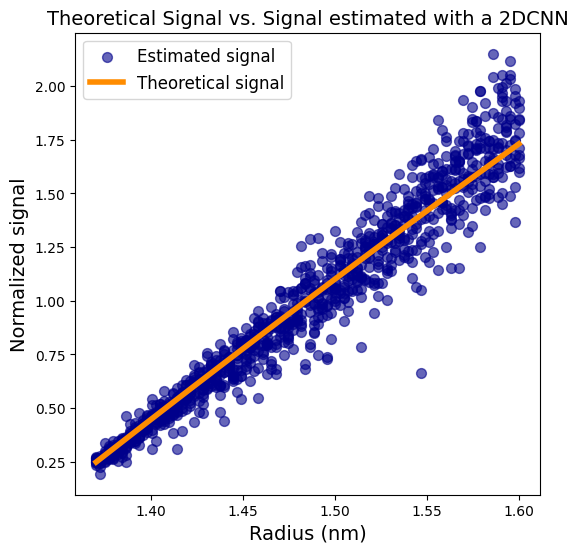

In [62]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, signal_sum_cnn_fix_radius, color="darkblue", alpha=0.6, s=50, label = 'Estimated signal')

#Line for theoretical
plt.plot(riis, theoretical_signal, linestyle="-", linewidth=4, label="Theoretical signal", color = 'darkorange')

plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Normalized signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical Signal vs. Signal estimated with a 2DCNN", fontsize=14)

## 4. Combining detection and quantification in ISCAT
xxx

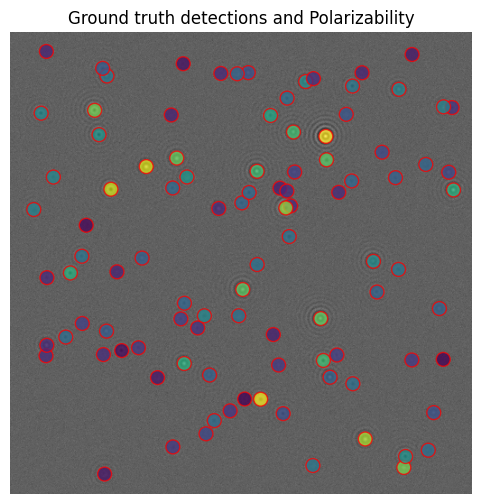

In [63]:
hp.plot_frame_with_detections_filled(
    data = data[...,0],
    positions = labels[:, :2],
    values = signal_rois,
    title = "Ground truth detections and Polarizability"
    )

### 4.2 LodeSTAR and 2DCNN for particle detection and quantification
xxx

In [64]:
def LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = 0.5, beta = 0.5, cutoff = 0.95, padsize = 20, downsample = False):

    #Detect particles with LodeSTAR
    if downsample:
        datav2 = skimage.measure.block_reduce(data, (2, 2, 1)) 
        torch_image = torch.from_numpy(datav2).permute(2, 0, 1).unsqueeze(0).float()
        factor = 2
    else:
        torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
        factor = 1

    detections = lodestar.detect(torch_image.to(DEV), alpha=alpha, beta=beta, 
                                    mode="quantile", cutoff=cutoff)[0]
    
    detections = detections*factor

    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([
            cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float().to(DEV)).cpu().detach().numpy()[0, 0] 
            for roi in hp.get_rois(data, detections, padsize)])

        return detections, signals

    else:
        print("No detections")

In [65]:
detections, signals = LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = alpha, beta = beta, cutoff = cutoff, padsize = 20, downsample = downsample)

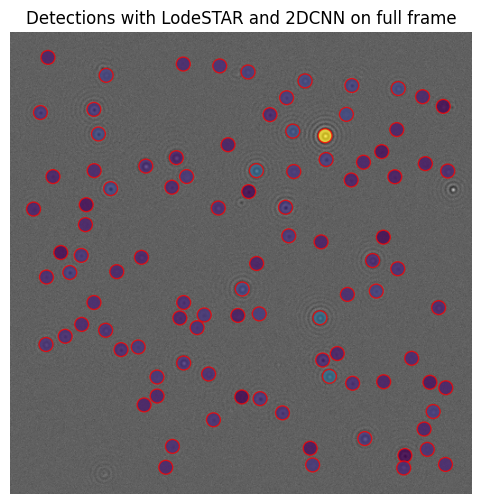

In [68]:
hp.plot_frame_with_detections_filled(
    data = data[...,0],
    positions = detections,
    values = signals,
    title = "Detections with LodeSTAR and 2DCNN on full frame"
    )